In [6]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_validate
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(20.0,10.0)})

### Загрузка таблицы

In [7]:
!gdown 16EBRCEGvdqw2kkqI5TJHrbmArTnz1wIw

Downloading...
From: https://drive.google.com/uc?id=16EBRCEGvdqw2kkqI5TJHrbmArTnz1wIw
To: /content/Dataset4.csv
100% 66.0M/66.0M [00:00<00:00, 218MB/s]


In [8]:
df = pd.read_csv('Dataset4.csv')

### Обработка данных

In [9]:
df = df.dropna(subset=['Technique'])
df.City = df.City.str.lower()
df = df[~df.City.isin(['online', 'the peninsula hotel shanghai', 'christie\'s special exhibition gallery', 'cowdray park'])]
df = df[~df.Technique.isin(['-'])]

df = df[~df.Currency.isin(['CNY', 'CHF', 'RMB', 'ESP'])]
df = df.replace({'Currency': {'GBP': 'USD'}})
df = df.replace({'Currency': {'HKD': 'USD'}})
df = df.replace({'Currency': {'EUR': 'USD'}})

df['Technique'] = df['Technique'].str.replace('\n','')
df['Technique'] = df['Technique'].str.replace(' ','')
df = df.replace({'Technique': {'watercolour': 'watercolor'}})

### Количество картин проданных в городах

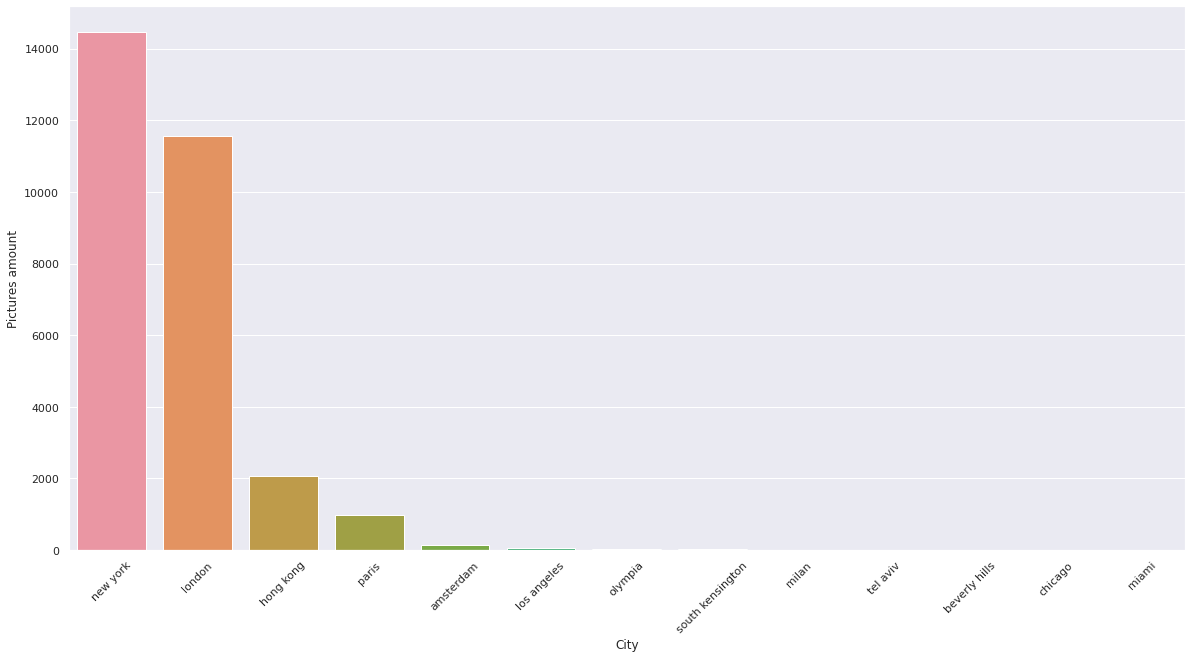

In [10]:
auctions_amount = df.value_counts("City").reset_index(name="Pictures amount")
figure = sns.barplot(data=auctions_amount, x="City", y="Pictures amount")
for item in figure.get_xticklabels():
    item.set_rotation(45)

### Средняя цена картины и техника рисования

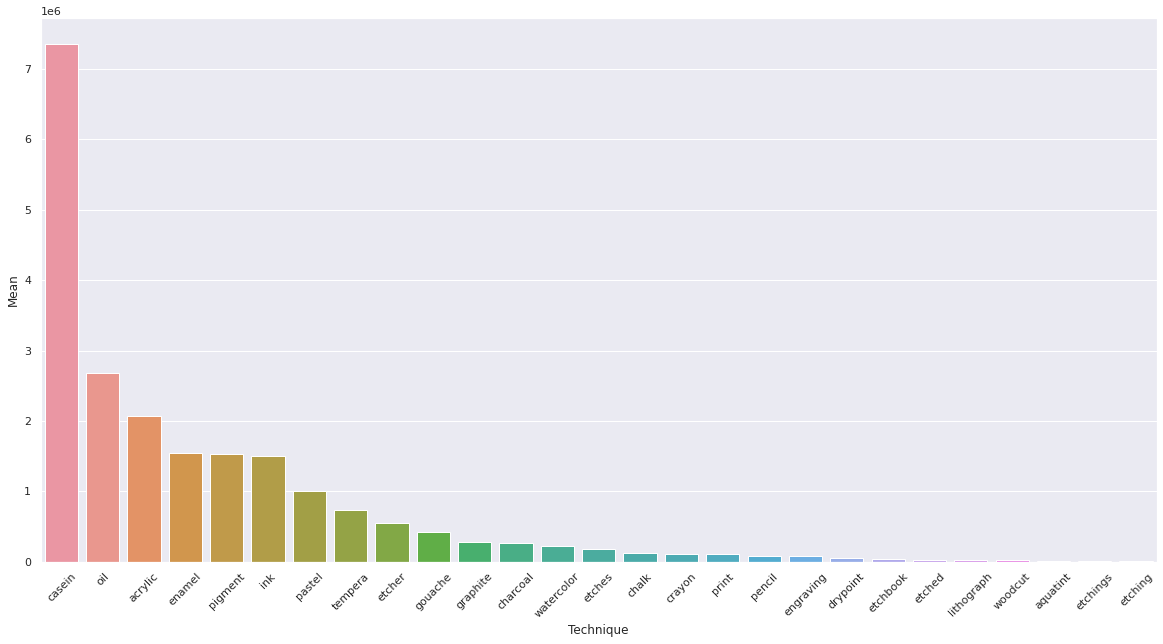

In [11]:
mean = df.groupby("Technique")["Price"].mean().sort_values(ascending=False).reset_index(name="Mean")

figure = sns.barplot(data=mean, x="Technique", y="Mean")
for item in figure.get_xticklabels():
    item.set_rotation(45)

### Средняя цена картины и национальность художника

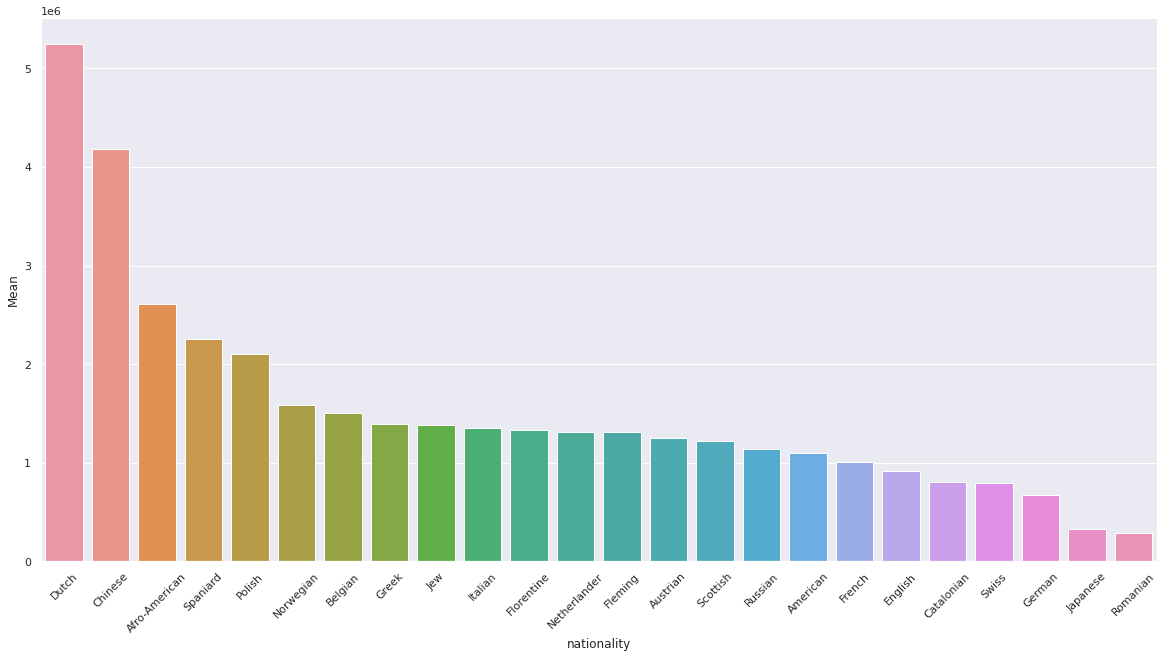

In [12]:
mean = df.groupby("nationality")["Price"].mean().sort_values(ascending=False).reset_index(name="Mean")

figure = sns.barplot(data=mean, x="nationality", y="Mean")
for item in figure.get_xticklabels():
    item.set_rotation(45)

### Зависимость между ценой и полом

<Axes: xlabel='sex', ylabel='Price'>

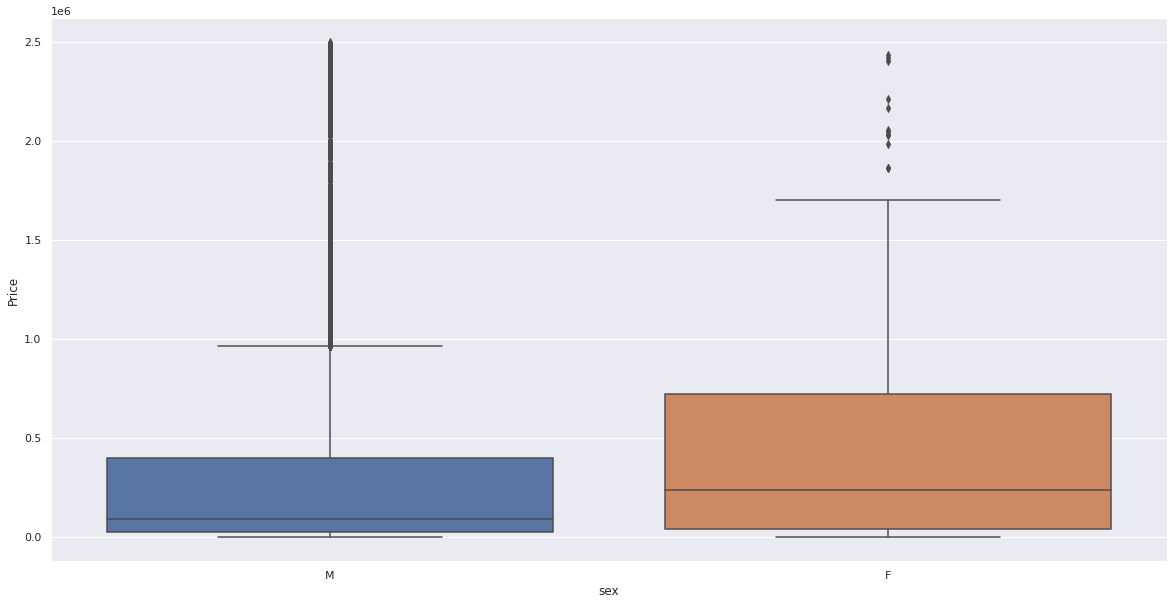

In [13]:
sns.boxplot(data=df[df.Price < 2500000], x="sex", y="Price")


### Зависимость ценой и размером картины

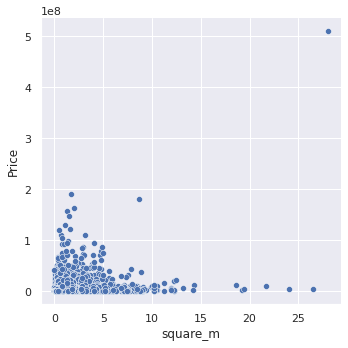

In [14]:
sns.relplot(data=df, x="square_m", y="Price")


### Зависимость

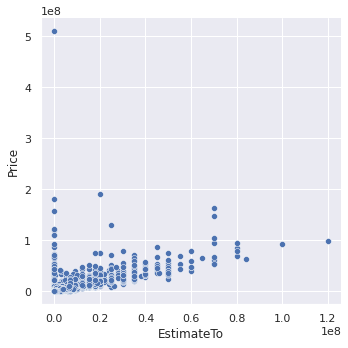

In [15]:
sns.relplot(data=df, x="EstimateTo", y="Price")


### Обучение модели без параметра `EstimateFrom`



In [16]:
df = df[df.Author.isin(['andy warhol', 'pablo picasso', 'marc chagall', 'pierre-auguste renoir', 'henri matisse'])]
df = df[df.Technique.isin(['oil', 'ink', 'print', 'lithograph', 'acrylic'])]
df = df[df.Material.isin(['paper', 'canvas', 'board', 'linoleum', 'panel'])]
df = df[df.City.isin(['new york', 'london', 'paris', 'hong kong', 'olympia'])]


X = df[['Author', 'Technique', 'Material', 'style', 'Sign', 'square_m', 'City']]
y = df['Price']

dummy_X = pd.get_dummies(X, prefix=['col1', 'col2', 'col3','col4', 'col5'])

X_train, X_test, y_train, y_test = train_test_split(dummy_X, y, test_size=0.75, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print(r2_score(y_test, y_pred))


0.019647864010794436


###Обучение модели с параметром `EstimateFrom`

In [17]:
X = df[['Author', 'Technique', 'Material', 'style', 'Sign', 'square_m', 'City', 'EstimateFrom']]
y = df['Price']

X = pd.get_dummies(X, prefix=['col1', 'col2', 'col3', 'col4', 'col5'])

k_fold = KFold(n_splits=4, shuffle=True, random_state=42)
models = [LinearRegression(), DecisionTreeRegressor(), GradientBoostingRegressor()]

for model in models:
    r2_values = []

    for train_index, test_index in k_fold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        r2_values.append(r2_score(y_test, model.predict(X_test)))

    print(model.__class__.__name__)
    print(f'Mean R2: {np.mean(r2_values)}')
    print()

LinearRegression
Mean R2: 0.8207120281391521

DecisionTreeRegressor
Mean R2: 0.7521191306433355

GradientBoostingRegressor
Mean R2: 0.8323815852200277



In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

model = GradientBoostingRegressor()

params = {
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'n_estimators': [1, 10, 100, 500, 1000],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_features': ['auto', 'sqrt', 'log2'],
}

grid_search = GridSearchCV(estimator=model, param_grid=params, cv=4, verbose=10)
grid_search.fit(X_train, y_train)

print()
print(f'Best params: {grid_search.best_params_}\n')

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print('R2: ', r2_score(y_test, y_pred))

Fitting 4 folds for each of 120 candidates, totalling 480 fits
[CV 1/4; 1/120] START criterion=friedman_mse, loss=squared_error, max_features=auto, n_estimators=1
[CV 1/4; 1/120] END criterion=friedman_mse, loss=squared_error, max_features=auto, n_estimators=1;, score=0.162 total time=   0.0s
[CV 2/4; 1/120] START criterion=friedman_mse, loss=squared_error, max_features=auto, n_estimators=1
[CV 2/4; 1/120] END criterion=friedman_mse, loss=squared_error, max_features=auto, n_estimators=1;, score=0.141 total time=   0.0s
[CV 3/4; 1/120] START criterion=friedman_mse, loss=squared_error, max_features=auto, n_estimators=1
[CV 3/4; 1/120] END criterion=friedman_mse, loss=squared_error, max_features=auto, n_estimators=1;, score=0.152 total time=   0.0s
[CV 4/4; 1/120] START criterion=friedman_mse, loss=squared_error, max_features=auto, n_estimators=1
[CV 4/4; 1/120] END criterion=friedman_mse, loss=squared_error, max_features=auto, n_estimators=1;, score=0.119 total time=   0.0s
[CV 1/4; 2/12